In [1]:
from paraview.simple import *

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

In [2]:
import matplotlib as mpl

mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['figure.labelsize'] = 'large'
mpl.rcParams['font.size'] = 15
mpl.rcParams['legend.fontsize'] = 'medium'
mpl.rcParams['legend.markerscale'] = 1.0
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 4.5
savefig_directory = '../Figures/'
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15

In [3]:
# Case files
folder = []
Setups = []
y_height = []
for foldername in os.listdir('results'):
    if os.path.isdir(os.path.join('results', foldername)):
        folder.append(f'results/{foldername}/touch.case')
        Setups.append(foldername)
        y_height.append(float(foldername.split('_')[1].split('m')[0]))

# Properties of interest with geometry storage
properties = ['Ma', 'T', 'p', 'U', 'rho']
store_files = ['Ma.png', 'T.png', 'p.png', 'U.png', 'rho.png']

In [4]:
# Load your case.foam file
# foamCase = [OpenFOAMReader(FileName=folder_) for folder_ in folder]
foamCase = [OpenFOAMReader(FileName=folder_) for folder_ in folder]

# Update pipeline to read the time steps, etc.
[foamCase_.UpdatePipeline() for foamCase_ in foamCase]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [5]:
foamCase_ = foamCase[0]

hasattr(foamCase_, "TimestepValues")
final_time = foamCase_.TimestepValues[-1]

In [ ]:
def store_geometry(foamCase, property, store_file):
    # Create a geometry view and show the data
    renderView = GetActiveViewOrCreate('RenderView')
    SetActiveSource(foamCase)
    display = Show(foamCase, renderView)
    
    # If foamCase has multiple time steps, update to the final time step.
    if hasattr(foamCase, "TimestepValues"):# and foamCase.TimestepValues:
        # final_time = foamCase.TimestepValues[-1]
        # UpdatePipeline(time=final_time)
        final_time = foamCase_.TimestepValues[-1]
        GetAnimationScene().AnimationTime = final_time
        renderView.Update()

    # Set properties to color by the specified property
    ColorBy(display, ('POINTS', property))
    display.RescaleTransferFunctionToDataRange(True)
    display.SetScalarBarVisibility(renderView, True)

    # Set the color map for the specific property
    lut = GetColorTransferFunction(property)
    lut.ApplyPreset('Cool to Warm', True)
    display.SetRepresentationType('Surface')
    display.SetScalarBarVisibility(renderView, True)

    # Set the camera
    # Reset the camera to what would be the default in ParaView
    ResetCamera()
    # Apply camera parallel projection (orthographic view)
    renderView.CameraParallelProjection = 1
    # Show the orientation axes for better spatial reference
    renderView.OrientationAxesVisibility = 1
    # Set the background color to white
    renderView.Background = [1.0, 1.0, 1.0]
    # Set the view size
    LoadPalette('WhiteBackground')
    renderView.ViewSize = [600, 600]

    # Store a figure
    if store_file is not None:
        # Make sure directory exists before saving
        store_dir = os.path.dirname(store_file)
        if store_dir and not os.path.exists(store_dir):
            os.makedirs(store_dir, exist_ok=True)
        SaveScreenshot(store_file, renderView, magnification=2, quality=100)

    # Clean up
    Delete(display)
    Delete(renderView)

: 

In [ ]:
# Cutplots
os.makedirs('Figures', exist_ok=True)
# Loop over different geometries
for i, foamCase_ in tqdm(enumerate(foamCase)):
    # Set the active source to the current foamCase
    # Loop through each property and store the geometry
    store_file = f'Figures/{Setups[i]}'
    os.makedirs(store_file, exist_ok=True)
    # print(f'store_file: {store_file}')
    for property, store_file_ in zip(properties, store_files):
            store_file_ = f'{store_file}/{store_file_}'
            # print(f'store_file_: {store_file_}')
            store_geometry(foamCase_, property, store_file_)

1it [00:01,  1.06s/it]

In [ ]:
def store_lineplot(foamCase, Point1, Point2, store_file, convergence=False):
    """
    Extract data along a line between Point1 and Point2, and save it to a CSV file.
    
    Parameters:
    -----------
    foamCase: paraview.servermanager.OpenFOAMReader
        The OpenFOAM reader object to extract data from
    Point1: list
        The starting point coordinates [x, y, z]
    Point2: list
        The ending point coordinates [x, y, z]
    store_file: str
        Path to save the CSV file
    """
    # Retrieve data information
    dataInfo = foamCase.GetDataInformation()

    # Get the total number of points (nodes) and cells
    total_points = dataInfo.GetNumberOfPoints()
    total_cells = dataInfo.GetNumberOfCells()

    print("Total number of points:", total_points)
    print("Total number of cells:", total_cells)
    # Create a render view for the pipeline
    renderView = GetActiveViewOrCreate('RenderView')

    # If foamCase has multiple time steps, update to the final time step.
    if hasattr(foamCase, "TimestepValues"):# and foamCase.TimestepValues:
        # final_time = foamCase.TimestepValues[-1]
        # UpdatePipeline(time=final_time)
        final_time = foamCase_.TimestepValues[-1]
        GetAnimationScene().AnimationTime = final_time
        renderView.Update()
    
    # Extract properties along a line
    lineSource = PlotOverLine(Input=foamCase)
    lineSource.Point1 = Point1
    lineSource.Point2 = Point2
    lineDisplay = Show(lineSource, renderView)
    lineDisplay.UpdatePipeline()

    # Render the view
    Render()

    # Make sure directory exists before saving
    store_dir = os.path.dirname(store_file)
    if store_dir and not os.path.exists(store_dir):
        os.makedirs(store_dir, exist_ok=True)
    
    # Add file extension if not present
    if not store_file.endswith('.csv'):
        store_file = store_file + '/lineplot.csv'
    
    # Save the line plot
    SaveData(store_file, proxy=lineSource)

    # Clean up
    Delete(lineSource)
    Delete(lineDisplay)
    Delete(renderView)

    if convergence:
        return total_points, total_cells

In [ ]:
# def plot_all_geometries(df, entry, angles, xlabel, ylabel, title, savefig=None, colors=colors):
#     fig, axs = plt.subplots()
#     for i, df_ in enumerate(df):
#         xaxis = df_['Points:0'].values
#         axs.plot(
#             xaxis, df_[entry] / df_[entry].values[-1], 
#             label=f'$\Theta$ = {Theta[i]}°', 
#             color=colors[i]
#         )
#     axs.set_xlabel(xlabel)
#     axs.set_ylabel(ylabel)
#     fig.suptitle(title)
#     axs.legend()
#     fig.tight_layout()
#     # if savefig is not None:
#     #     fig.savefig(savefig, bbox_inches='tight')
#     fig.show()

In [ ]:
# # Loop over different geometries
# for i, foamCase_ in tqdm(enumerate(foamCase)):
#     store_lineplot(foamCase_, Point1, Point2_vec[i], csv_files[i])

In [ ]:
# # Load the line plot data
# df = [pd.read_csv(csv_file) for csv_file in csv_files]

In [ ]:
store_lineplot(foamCase[0], [0, 0.5, 1], [2.5, 0.5, 1], 'rho_temp.csv')
df_rho = pd.read_csv('rho_temp.csv')
rho1 = df_rho['rho'].values[0]
os.remove('rho_temp.csv')
print(f'rho1: {rho1}')

Total number of points: 121002
Total number of cells: 60000
rho1: 1.174


In [ ]:
# Inflow
M1 = 2.
T1 = 300.
p1 = 101325.

# True outflow
M2_true = [2, 1.852, 1.587, 1.486, 1.229, 0.917]
rho2rho1_true = [1, 1.201, 1.491, 1.714, 2.027, 2.379]
p2p1_true = [1, 1.293, 1.761, 2.167, 2.810, 3.667]
T2T1_true = [1, 1.077, 1.182, 1.264, 1.386, 1.541]

In [ ]:
# # Loop over different geometries
# EPS = 0.0001
# Point1_vec = [[1.5, 0, 1.0] for point2 in Point2_y]
# Point2_vec = [[2.5, point2+EPS, 1.0] for point2 in Point2_y]
# csv_files_shock = [f'Figures/angle_value_{angle}_shock/lineplot.csv' for angle in angles]
# csv_files_upstream = [f'Figures/angle_value_{angle}_upstream/lineplot.csv' for angle in angles]

# # Extract data for upstream and shock lines for each case
# for i, foamCase_ in tqdm(enumerate(foamCase)):
#     # Create directories if they don't exist
#     os.makedirs(f'Figures/angle_value_{angles[i]}_upstream', exist_ok=True)
#     os.makedirs(f'Figures/angle_value_{angles[i]}_shock', exist_ok=True)
    
#     # Extract upstream data for this angle
#     upstream_csv = csv_files_upstream[i]
#     store_lineplot(foamCase_, [0.0, 0.0, 1.0], [1.5, 0.0, 1.0], upstream_csv)
    
#     # Extract shock line data for this angle
#     store_lineplot(foamCase_, Point1_vec[i], Point2_vec[i], csv_files_shock[i])
    
# # Load the line plot data
# df_upstream = [pd.read_csv(csv_file) for csv_file in csv_files_upstream]
# df_shock_original = [pd.read_csv(csv_file) for csv_file in csv_files_shock]

# # Combine upstream data with shock data for each angle
# df_shock = []
# for i, (df_up, df_sh) in enumerate(zip(df_upstream, df_shock_original)):
#     # Combine the upstream and shock data for each case
#     df_shock_combined = pd.concat([df_up, df_sh], ignore_index=True)
#     df_shock.append(df_shock_combined)

In [ ]:
# Loop over different geometries
EPS = 0.0001
Point1_vec = [[0.0, point2+EPS, 1.0] for point2 in y_height]
Point2_vec = [[2.5, point2+EPS, 1.0] for point2 in y_height]
csv_files = [f'Figures/{setup}/lineplot.csv' for setup in Setups]
for i, foamCase_ in tqdm(enumerate(foamCase)):
    store_lineplot(foamCase_, Point1_vec[i], Point2_vec[i], csv_files[i])
# Load the line plot data
df_shock = [pd.read_csv(csv_file) for csv_file in csv_files]

1it [00:00,  8.05it/s]

Total number of points: 121002
Total number of cells: 60000


In [ ]:
# # Loop over different geometries
# EPS = 0.01#!0.0001
# # Create directory for temporary files
# os.makedirs('Figures/temp', exist_ok=True)
# csv_files = [f'Figures/{setup}/lineplot.csv' for setup in Setups]

# for i, foamCase_ in tqdm(enumerate(foamCase)):
#     # Make sure the output directory exists
#     os.makedirs(os.path.dirname(csv_files[i]), exist_ok=True)
    
#     # Extract upstream data from (0,0,1) to (1.5,0,1)
#     upstream_csv = f'Figures/temp/upstream_{i}.csv'
#     store_lineplot(foamCase_, [0.0, 0.0, 1.0], [1.4, 0.0, 1.0], upstream_csv)
    
#     # Extract shock data from (1.5,0,1) to (2.5, y_height[i], 1.0)
#     shock_csv = f'Figures/temp/shock_{i}.csv'
#     store_lineplot(foamCase_, [1.4, 0.0, 1.0], [2.5, y_height[i]+EPS, 1.0], shock_csv)
    
#     # Read both CSV files
#     df_upstream = pd.read_csv(upstream_csv)
#     df_shock_part = pd.read_csv(shock_csv)
    
#     # Combine them
#     df_combined = pd.concat([df_upstream, df_shock_part], ignore_index=True)
    
#     # Save the combined data
#     df_combined.to_csv(csv_files[i], index=False)
    
#     # Clean up temporary files
#     os.remove(upstream_csv)
#     os.remove(shock_csv)

# # Load the line plot data
# df_shock = [pd.read_csv(csv_file) for csv_file in csv_files]

<>:37: SyntaxWarning: invalid escape sequence '\T'
<>:40: SyntaxWarning: invalid escape sequence '\s'
<>:49: SyntaxWarning: invalid escape sequence '\T'
<>:37: SyntaxWarning: invalid escape sequence '\T'
<>:40: SyntaxWarning: invalid escape sequence '\s'
<>:49: SyntaxWarning: invalid escape sequence '\T'
/var/folders/v_/5q1gkdc53z34pdsfnpkx2t340000gn/T/ipykernel_74841/1349519142.py:37: SyntaxWarning: invalid escape sequence '\T'
  label=f'$\Theta = {angles[i]}°$, $M = {Mach_numbers[i]}$'
/var/folders/v_/5q1gkdc53z34pdsfnpkx2t340000gn/T/ipykernel_74841/1349519142.py:40: SyntaxWarning: invalid escape sequence '\s'
  axs[row, col].set_xlabel('x [m] at $y=\sin(\Theta)$')
/var/folders/v_/5q1gkdc53z34pdsfnpkx2t340000gn/T/ipykernel_74841/1349519142.py:49: SyntaxWarning: invalid escape sequence '\T'
  label=f'$\Theta = {angle}°$'))
/var/folders/v_/5q1gkdc53z34pdsfnpkx2t340000gn/T/ipykernel_74841/1349519142.py:60: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.s

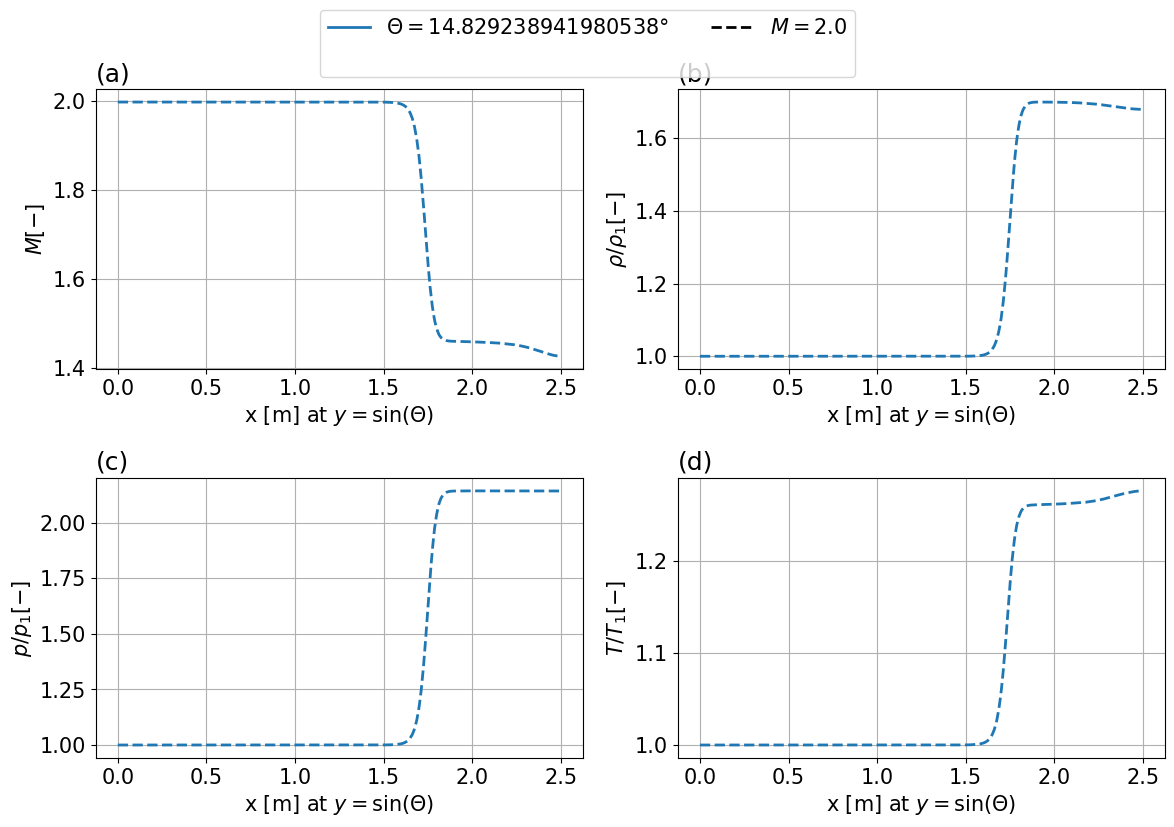

In [ ]:
# Extract Mach numbers and angle values from Setups
Mach_numbers = [float(setup.split('_')[0][1:]) for setup in Setups]
angles = [np.rad2deg(float(setup.split('_')[1])) for setup in Setups]

# Define unique angles and Mach numbers
unique_angles = sorted(list(set(angles)))
unique_mach = sorted(list(set(Mach_numbers)))

# Create mappings
angle_to_color = {angle: plt.cm.tab10(i) for i, angle in enumerate(unique_angles)}
mach_to_linestyle = {1.5: '-', 2.0: '--', 2.5: '-.'}

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
title = ['(a)', '(b)', '(c)', '(d)']
ylabels = ['$M [-]$', '$\\rho/\\rho_1 [-]$', '$p/p_1 [-]$', '$T/T_1 [-]$']

for enum, entry in enumerate(['Ma', 'rho', 'p', 'T']): 
    row, col = enum // 2, enum % 2
    for i, df_ in enumerate(df_shock):
        xaxis = df_['Points:0'].values
        y_values = df_[entry]
        
        # Normalize relative to inflow conditions, not outflow
        if entry == 'rho':
            y_values = y_values / rho1
        elif entry == 'p':
            y_values = y_values / p1
        elif entry == 'T':
            y_values = y_values / T1
            
        # Plot with color based on angle and linestyle based on Mach
        axs[row, col].plot(
            xaxis, 
            y_values,
            color=angle_to_color[angles[i]],
            linestyle=mach_to_linestyle[Mach_numbers[i]],
            label=f'$\Theta = {angles[i]}°$, $M = {Mach_numbers[i]}$'
        )
    
    axs[row, col].set_xlabel('x [m] at $y=\sin(\Theta)$')
    axs[row, col].set_ylabel(ylabels[enum])
    axs[row, col].set_title(title[enum], loc='left')

# Create custom legend elements
legend_elements = []
# Angle colors first
for angle in unique_angles:
    legend_elements.append(plt.Line2D([0], [0], color=angle_to_color[angle], 
                           label=f'$\Theta = {angle}°$'))
# Add separator
legend_elements.append(plt.Line2D([0], [0], color='none', label=' '))
# Mach number linestyles
for mach in unique_mach:
    legend_elements.append(plt.Line2D([0], [0], color='black', 
                           linestyle=mach_to_linestyle[mach], label=f'$M = {mach}$'))

fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=len(unique_angles)+len(unique_mach))
fig.tight_layout()
fig.savefig('Figures/angle_value_lineplot.pdf', bbox_inches='tight')
fig.show()

In [ ]:
# Create a table of all values at x=2.5 for each Mach number and angle
# Create empty lists to store the data
mach_list = []
angle_list = []
ma_list = []
rho_list = []
p_list = []
t_list = []

# Extract the data at x=2.5 for each simulation
for i, df in enumerate(df_shock):
    # Get the last row (x=2.5)
    last_row = df.iloc[-1]
    
    # Extract the values
    mach_list.append(Mach_numbers[i])
    angle_list.append(angles[i])
    ma_list.append(last_row['Ma'])
    rho_list.append(last_row['rho'] / rho1)
    p_list.append(last_row['p'] / p1)
    t_list.append(last_row['T'] / T1)

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'Mach': mach_list,
    'Angle (deg)': angle_list,
    'M2': ma_list,
    'rho2/rho1': rho_list,
    'p2/p1': p_list,
    'T2/T1': t_list
})

# Sort by Mach number and then by angle
results_df = results_df.sort_values(['Mach', 'Angle (deg)'])

# Display the table
display(results_df)

# Create a pivot table for better visualization
pivot_df = pd.pivot_table(
    results_df, 
    values=['M2', 'rho2/rho1', 'p2/p1', 'T2/T1'],
    index=['Angle (deg)'],
    columns=['Mach'],
    aggfunc='first'
)

# Display the pivot table
display(pivot_df)

# Save results to CSV files
results_df.to_csv('Figures/shock_results_table.csv', index=False)
pivot_df.to_csv('Figures/shock_results_pivot.csv')

# Create LaTeX code for a table with all properties grouped by Mach number
latex_table = [
    "\\begin{table}[htbp]",
    "\\centering",
    "\\caption{Oblique shock wave properties across different angles}",
    "\\begin{tabular}{lccccc}",
    "\\hline",
    "Mach & Angle (deg) & $M_2$ & $\\rho_2/\\rho_1$ & $p_2/p_1$ & $T_2/T_1$ \\\\",
    "\\hline"
]

# Group by Mach number
for mach in sorted(results_df['Mach'].unique()):
    mach_data = results_df[results_df['Mach'] == mach]
    first_row = True
    for _, row in mach_data.iterrows():
        angle = row['Angle (deg)']
        m2 = f"{row['M2']:.4f}"
        rho_ratio = f"{row['rho2/rho1']:.4f}"
        p_ratio = f"{row['p2/p1']:.4f}"
        t_ratio = f"{row['T2/T1']:.4f}"
        
        if first_row:
            latex_table.append(f"{mach} & {angle} & {m2} & {rho_ratio} & {p_ratio} & {t_ratio} \\\\")
            first_row = False
        else:
            latex_table.append(f" & {angle} & {m2} & {rho_ratio} & {p_ratio} & {t_ratio} \\\\")
    
    latex_table.append("\\hline")

latex_table.extend([
    "\\end{tabular}",
    "\\label{tab:shock_properties}",
    "\\end{table}"
])

print("LaTeX Table Code:")
print("\n".join(latex_table))

,Mach,Angle (deg),M2,rho2/rho1,p2/p1,T2/T1
0,2.0,14.829239,1.427,1.679216,2.143203,1.276267


,M2,T2/T1,p2/p1,rho2/rho1
Mach,2.0,2.0,2.0,2.0
Angle (deg),,,,
14.829239,1.427,1.276267,2.143203,1.679216


LaTeX Table Code:
\begin{table}[htbp]
\centering
\caption{Oblique shock wave properties across different angles}
\begin{tabular}{lccccc}
\hline
Mach & Angle (deg) & $M_2$ & $\rho_2/\rho_1$ & $p_2/p_1$ & $T_2/T_1$ \\
\hline
2.0 & 14.829238941980538 & 1.4270 & 1.6792 & 2.1432 & 1.2763 \\
\hline
\end{tabular}
\label{tab:shock_properties}
\end{table}


<>:41: SyntaxWarning: invalid escape sequence '\T'
<>:44: SyntaxWarning: invalid escape sequence '\s'
<>:55: SyntaxWarning: invalid escape sequence '\T'
<>:41: SyntaxWarning: invalid escape sequence '\T'
<>:44: SyntaxWarning: invalid escape sequence '\s'
<>:55: SyntaxWarning: invalid escape sequence '\T'
/var/folders/v_/5q1gkdc53z34pdsfnpkx2t340000gn/T/ipykernel_74841/1450208365.py:41: SyntaxWarning: invalid escape sequence '\T'
  label=f'$\Theta = {angles[i]}°$, $M = {Mach_numbers[i]}$'
/var/folders/v_/5q1gkdc53z34pdsfnpkx2t340000gn/T/ipykernel_74841/1450208365.py:44: SyntaxWarning: invalid escape sequence '\s'
  axs[row, col].set_xlabel('x [m] at $y=\sin(\Theta)$')
/var/folders/v_/5q1gkdc53z34pdsfnpkx2t340000gn/T/ipykernel_74841/1450208365.py:55: SyntaxWarning: invalid escape sequence '\T'
  label=f'$\Theta = {angle}°$')
/var/folders/v_/5q1gkdc53z34pdsfnpkx2t340000gn/T/ipykernel_74841/1450208365.py:70: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.sh

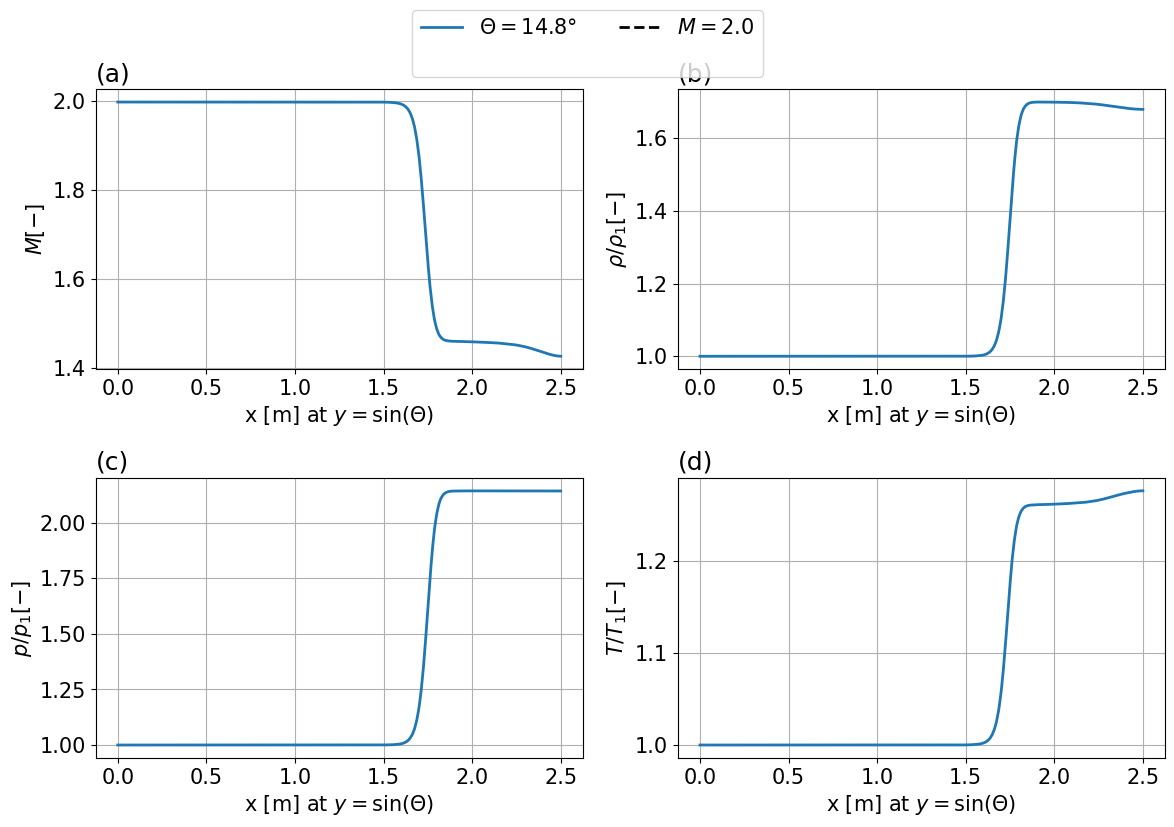

In [ ]:
# Extract Mach numbers and angle values from Setups
Mach_numbers = [float(setup.split('_')[0][1:]) for setup in Setups]
angles = [round(float(setup.split('_')[1]) * 180 / np.pi, 1) for setup in Setups]
# angles = [np.rad2deg(float(setup.split('_')[1])) for setup in Setups]
# angles = [0, 5, 10, 15, 20, 25]

# Define unique angles and Mach numbers
unique_angles = sorted(list(set(angles)))
unique_mach = sorted(list(set(Mach_numbers)))

# Create mappings
angle_to_color = {angle: plt.cm.tab10(i) for i, angle in enumerate(unique_angles)}
mach_to_linestyle = {1.5: '-', 2.0: '--', 2.5: '-.'}

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
title = ['(a)', '(b)', '(c)', '(d)']
ylabels = ['$M [-]$', '$\\rho/\\rho_1 [-]$', '$p/p_1 [-]$', '$T/T_1 [-]$']

for enum, entry in enumerate(['Ma', 'rho', 'p', 'T']): 
    row, col = enum // 2, enum % 2
    for i, df_ in enumerate(df_shock):
        if Mach_numbers[i] in [1.5, 2.5]:
            continue
        xaxis = df_['Points:0'].values
        y_values = df_[entry]
        
        # Normalize relative to inflow conditions, not outflow
        if entry == 'rho':
            y_values = y_values / rho1
        elif entry == 'p':
            y_values = y_values / p1
        elif entry == 'T':
            y_values = y_values / T1
            
        # Plot with color based on angle and linestyle based on Mach
        axs[row, col].plot(
            xaxis, 
            y_values,
            color=angle_to_color[angles[i]],
            linestyle='-',
            label=f'$\Theta = {angles[i]}°$, $M = {Mach_numbers[i]}$'
        )
    
    axs[row, col].set_xlabel('x [m] at $y=\sin(\Theta)$')
    axs[row, col].set_ylabel(ylabels[enum])
    axs[row, col].set_title(title[enum], loc='left')

# Create custom legend elements
legend_elements = []
# Angle colors first
for angle in unique_angles:
    legend_elements.append(
        plt.Line2D(
            [0], [0], color=angle_to_color[angle], 
            label=f'$\Theta = {angle}°$')
        )
# Add separator
legend_elements.append(plt.Line2D([0], [0], color='none', label=' '))
# Mach number linestyles
for mach in unique_mach:
    legend_elements.append(
        plt.Line2D(
            [0], [0], color='black', 
            linestyle=mach_to_linestyle[mach], label=f'$M = {mach}$')
        )

fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=len(unique_angles)+len(unique_mach))
fig.tight_layout()
fig.savefig('Figures/angle_value_lineplot.pdf', bbox_inches='tight')
fig.show()

## Residuals

In [ ]:
def extract_residuals(case_reader):
    """Extract residual data from a case reader for all properties."""
    # Get the available time steps
    timeSteps = case_reader.TimestepValues
    local_residuals = {}
    
    for prop in properties:
        local_residuals[prop] = {'avg': [], 'min': [], 'max': []}
    
    # Create a render view for the pipeline
    renderView = GetActiveViewOrCreate('RenderView')
    SetActiveSource(case_reader)
    
    # Loop through time steps to extract residual data
    for time in tqdm(timeSteps, desc=f"Processing case"):
        case_reader.UpdatePipeline(time)
        
        # Extract data for each property
        for prop in properties:
            # Get data for the current property at this time step
            dataInfo = case_reader.GetDataInformation().GetPointDataInformation().GetArrayInformation(prop)
            if dataInfo:
                # Extract range values
                range_values = dataInfo.GetComponentRange(0)
                local_residuals[prop]['min'].append(range_values[0])
                local_residuals[prop]['max'].append(range_values[1])
                
                # For average, use a calculator filter
                calculator = Calculator(Input=case_reader)
                calculator.Function = prop
                calculator.ResultArrayName = f"{prop}_value"
                calculator.UpdatePipeline(time)
                calc_data = servermanager.Fetch(calculator)
                
                # Process the data to calculate average
                values = []
                if calc_data.GetNumberOfBlocks() > 0:
                    for i in range(calc_data.GetNumberOfBlocks()):
                        block = calc_data.GetBlock(i)
                        if block and block.GetPointData().GetNumberOfArrays() > 0:
                            data_array = block.GetPointData().GetArray(f"{prop}_value")
                            if data_array:
                                for j in range(data_array.GetNumberOfTuples()):
                                    values.append(data_array.GetValue(j))
                
                avg = sum(values) / len(values) if values else 0
                local_residuals[prop]['avg'].append(avg)
                Delete(calculator)
    
    # Clean up
    Delete(renderView)
    
    return local_residuals

In [ ]:
# Create structures to store residual data
residuals = {}
for prop in properties:
    residuals[prop] = {'avg': [], 'min': [], 'max': []}

# Create directory for saving residuals
os.makedirs('Figures/Residuals', exist_ok=True)

# Process all cases
for i, case in enumerate(tqdm(foamCase, desc="Processing cases")):
    print(f"Extracting residuals for case {i+1}/{len(foamCase)} (angle {angles[i]})")
    case_residuals = extract_residuals(case)
    
    # Save residuals to file for each case
    for prop in properties:
        for res_type in ['avg', 'min', 'max']:
            residuals[prop][res_type] = case_residuals[prop][res_type]
    
    # Save the residuals data to file
    residual_file = f'Figures/Residuals/{Setups[i]}.npz'
    np.savez(
        residual_file, 
        Ma_avg=case_residuals['Ma']['avg'], Ma_min=case_residuals['Ma']['min'], Ma_max=case_residuals['Ma']['max'],
        T_avg=case_residuals['T']['avg'], T_min=case_residuals['T']['min'], T_max=case_residuals['T']['max'],
        p_avg=case_residuals['p']['avg'], p_min=case_residuals['p']['min'], p_max=case_residuals['p']['max'],
        U_avg=case_residuals['U']['avg'], U_min=case_residuals['U']['min'], U_max=case_residuals['U']['max']
    )
    
    # Also create individual plots for each case
    fig, axs = plt.subplots(len(properties), 1, figsize=(10, 12), sharex=True)
    
    for j, prop in enumerate(properties):
        times = np.arange(len(case_residuals[prop]['avg']))
        axs[j].loglog(times, case_residuals[prop]['avg'], 'b-', label='Average')
        axs[j].loglog(times, case_residuals[prop]['min'], 'g--', label='Minimum')
        axs[j].loglog(times, case_residuals[prop]['max'], 'r--', label='Maximum')
        axs[j].set_ylabel(f'{prop}')
        axs[j].grid(True)
        axs[j].legend()
    
    axs[-1].set_xlabel('Time Step')
    fig.suptitle(f'Property Residuals Over Time - Angle {angles[i]}')
    fig.tight_layout()
    plt.savefig(f'Figures/Residuals/{Setups[i]}.pdf', bbox_inches='tight')
    plt.close(fig)

Processing cases:   0%|          | 0/1 [00:00<?, ?it/s]

Extracting residuals for case 1/1 (angle 14.8)


Processing cases: 100%|██████████| 1/1 [00:02<00:00,  2.04s/it]
